In [1]:
! /home/ec2-user/anaconda3/envs/pytorch_latest_p36/bin/python -m pip install --upgrade pip
! pip3 install detecto

  Using cached pip-20.2.4-py2.py3-none-any.whl (1.5 MB)
  Attempting uninstall: pip
    Found existing installation: pip 20.0.2
    Uninstalling pip-20.0.2:
      Successfully uninstalled pip-20.0.2


In [2]:
from detecto.core import Model

weights = "model_weights.pth"
labels = ["traffic-light", "crosswalk", "manhole", "traffic-cone", "bike-lane", "pedestrian"]

iterations = 10

model = Model.load(weights, labels)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /home/ec2-user/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


In [ ]:
#TRAIN MODEL
from detecto.core import Dataset
import matplotlib.pyplot as plt

training_dataset = Dataset('train/')
validation_dataset = Dataset('validate/')

losses = model.fit(training_dataset, validation_dataset, epochs=iterations, verbose=True)

plt.plot(losses)
plt.show()

In [ ]:
# save model weights for further iterations

model.save("model_weights.pth")

In [3]:
# method to create an array of object counts corresponding to the `labels` array

def count_labels(test_labels, test_scores, confidence):
    count = [0 for label in labels]
    
    for j in range(len(test_labels)):
        if test_scores[j] > confidence:
            count[labels.index(test_labels[j])] += 1 #by indexing with the labels array, the count array is formatted in the same order
    return count

In [4]:
def count_label_data(file_contents):
    totals = [0 for label in labels]
    
    for i in range(len(labels)):
        totals[i] = file_contents.count(labels[i])
    return totals

processing: D0jT8piaWW9ndvvfUviSRQ.jpg
processing: D9yEFdpkv9Ly285Brdsydw.jpg
processing: YIfJz9uVUNXNwpwBs1DXcg.jpg
processing: YIxgZYdnCt82fIubMEx5jg.jpg
processing: YK11CuhJxHSOplLIsvVbBQ.jpg
processing: YM2-lT6bZU1eNULcXi6tbw.jpg
processing: YMf3UqqHrF3mM8vmn8hW7w.jpg
processing: YQXgEhyS4CF4X7YvRRsZrw.jpg
processing: YQ_Iqfbbk7g2x60VQ2N5Dg.jpg
processing: YRdV3a7ZOExoMKyAJb0LJQ.jpg
processing: YRgWE2RadNc9pZqyWEa2Ow.jpg
processing: YVbZAoBngxpzTseRnEuyLQ.jpg
processing: YVrEbUT4JAagA_HuCgWjTQ.jpg
processing: YYWaU2ytAech8u52CgtWiw.jpg
processing: YZ7qIO04lmAutpyn49_Y0w.jpg
processing: YZUF1XkrXWgN-Dol63QPxQ.jpg
processing: YdLJqPROdacw_KkYZeUMIw.jpg
processing: Yf6OFLTxxF_mhto8gyaKZg.jpg
processing: YfooLiEoLE_quCc-aB98jA.jpg
processing: YftxY7pM6lM0z59kA9VbFg.jpg
processing: Ygni6ulCny5i-r4uWhqK-A.jpg
processing: YhNVWVYOpJtDrTPcWezAoA.jpg
processing: Yn2fWYJpDWZVwNsjEiFA7A.jpg
processing: YoefkQrDl2iy61CYi_DxlQ.jpg
processing: YuxsO9Y-j-z-H0Ehls2pLg.jpg
processing: YwBEeLXGRF2hx

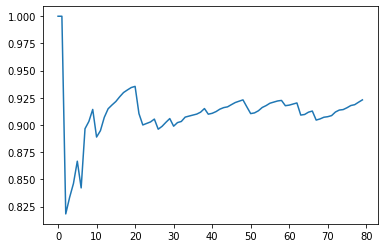

In [6]:
#test validation set for accuracy

import os
from os import listdir, O_RDONLY
from os.path import isfile, join
from detecto.utils import read_image
import matplotlib.pyplot as plt

labels = ["traffic-light", "crosswalk", "manhole", "traffic-cone", "bike-lane", "pedestrian"]
byte_limit = 4096

val_dir = "validate/"
val_data = [file for file in listdir(val_dir) if isfile(join(val_dir, file))]

val_images = [file for file in val_data if file.split(".")[1]=="jpg"]
val_labels = [file for file in val_data if file.split(".")[1]=="xml"]

val_images.sort()
val_labels.sort()

total_identified = 0
total_existing = 0
accuracy_tracker = []

for i in range(len(val_images)):
    fd = os.open("{0}{1}".format(val_dir,val_labels[i]), O_RDONLY)
    print("processing: {}".format(val_images[i]))

    file_contents = os.read(fd, byte_limit).decode()
    label_data = count_label_data(file_contents)

    total_existing += sum(label_data)

    #get predictions from model on validation image
    image = read_image("{0}{1}".format(val_dir, val_images[i]))
    test_labels, test_boxes, test_scores = model.predict(image)

    label_predictions = count_labels(test_labels, test_scores, 0.4)

    for j in range(len(label_predictions)):
        total_identified += min(label_predictions[j], label_data[j])
    os.close(fd)
    accuracy_tracker.append(total_identified / total_existing)

print("validation_set accuracy: {}".format(total_identified / total_existing))
plt.plot(accuracy_tracker)
plt.show()    

In [ ]:
# test model against new image set

import os
from os import listdir, O_RDWR, O_CREAT
from os.path import isfile, join
from detecto.utils import read_image

#define testing images
test_dir = "test/"
test_images = [file for file in listdir(test_dir) if isfile(join(test_dir, file))]

#open results and log files
fd1 = os.open("test_results.txt", O_RDWR | O_CREAT)
fd2 = os.open("test_logs.txt", O_RDWR | O_CREAT)

#add header to results file
formatted_labels = "{:26}".format("image")
for label in labels:
    formatted_labels += "{:>14}".format(label)
formatted_labels += "\n"

os.write(fd1, formatted_labels.encode())

for i in range(len(test_images)):
    #set filename and make predictions
    image = read_image("{0}{1}".format(test_dir, test_images[i]))
    test_labels, test_boxes, test_scores = model.predict(image)
    
    #write to log file
    os.write(fd2, ("image: {}\n".format(test_images[i])).encode())
    for j in range(len(test_labels)):
        os.write(fd2, ("label: {0}\t\tbox: {1}\tscore: {2}\n".format(test_labels[j], str(test_boxes[j]), str(test_scores[j]))).encode())
    os.write(fd2, "\n".encode())
    
    if len(test_labels) == 0:
        os.write(fd2, "N/A\n".encode())
    
    #count objects and format for results file
    object_counts = count_labels(test_labels, test_scores)
    object_counts = [str(count) for count in object_counts]
    formatted_object_counts = test_images[i]
    for count in object_counts:
        formatted_object_counts += "{:>14}".format(count)
    formatted_object_counts += "\n\n"
    
    #format rows with separation
    os.write(fd1, formatted_object_counts.encode())
    os.write(fd1, ("-" * (26 + 14 * 6) + "\n").encode())

os.close(fd1)
os.close(fd2)

In [ ]:
# test on new images

from detecto.utils import read_image
from detecto.visualize import show_labeled_image

image01 = read_image('test01.jpg')
image02 = read_image('test02.jpg')
image03 = read_image('test03.jpg')

images = [image01, image02, image03]

for i in range(len(images)):
    print("image: {}".format(i))
    test_labels, test_boxes, test_scores = model.predict_top(images[i])
    for j in range(len(test_boxes)):
        print("label: {0}\t\tbox: {1}\t\tscore: {2}".format(test_labels[j], test_boxes[j], test_scores[j]))
    show_labeled_image(images[i], test_boxes, test_labels)